# Data Science: Coursework 2

### Shri Lekkala
### CID: 01499487

### Table of Contents

* [Task 1](#t1) 
    * [Question 1.1](#q1_1)
        * [Part 1.1.1](#1_1_1)
        * [Part 1.1.2](#1_1_2)
        * [Part 1.1.3](#1_1_3)
    * [Question 1.2](#q1_2)
        * [Part 1.2.1](#1_2_1)
        * [Part 1.2.2](#1_2_2)
        * [Part 1.2.3](#1_2_3)
        * [Part 1.2.4](#1_2_4)
* [Task 2](#t2)
    * [Question 2.1](#q2_1)
        * [Part 2.1.1](#2_1_1)
        * [Part 2.1.2](#2_1_2)
        * [Part 2.1.3](#2_1_3)
    * [Question 2.2](#q2_2)
        * [Part 2.2.1](#2_2_1)
        * [Part 2.2.2](#2_2_2)
    * [Question 2.3](#q2_3)
        * [Part 2.3.1](#2_3_1)
        * [Part 2.3.2](#2_3_2)
        * [Part 2.3.3](#2_3_3)

In [1]:
# Import modules used throughout the coursework
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import time

# Set a random seed to fix the results
np.random.seed(1024)

## Task 1: Neural Networks <a class="anchor" id="t1"></a>
***

### 1.1 Multi-Layer Perceptron <a class="anchor" id="q1_1"></a>
***

#### Question 1.1.1 <a class="anchor" id="1_1_1"></a>
***

First we load the dataset:

In [2]:
def load_data ():
    (x_train, y_train), (x_val, y_val) = tf.keras.datasets.cifar10.load_data()
    x_train = x_train.astype('float32') / 255
    x_val = x_val.astype('float32') / 255
    
    # convert labels to categorical samples
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
    return ((x_train, y_train), (x_val, y_val))

(x_train, y_train), (x_val, y_val) = load_data()

We can check the shapes of each of the relevant datasets:

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


To get an idea of the outputs, we can add the list of label names corresponding to each class of the output, and  plot a randomly selected example from each class:

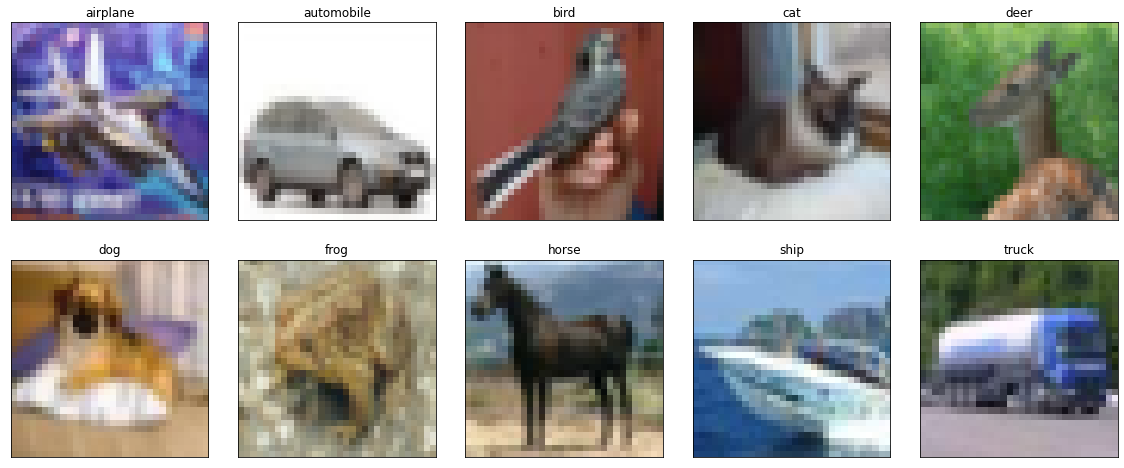

In [180]:
# Load the list of label names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot a randomly selected example from each class
n_rows, n_cols = 2, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.1)

for l, label_name in enumerate(classes):
    row = l // n_cols
    col = l % n_cols
        
    inx = np.where(y_train_labels == l)[0]
    i = np.random.choice(inx)
    x_example = x_train[i]
    
    axes[row, col].imshow(x_example)
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
    axes[row, col].set_title(label_name)

plt.show()

We process the data into numpy arrays for use in this section:

In [5]:
# Convert the data into 2D numpy arrays
X_train_np = np.reshape(np.array(x_train), (50000, 3072), order='C').T
X_test_np = np.reshape(np.array(x_val), (10000, 3072), order='C').T
y_train_np = np.array(y_train).T
y_test_np = np.array(y_val).T

# Convert the one-hot vector of labels of 0s and 1s into an integer between 0 and 9
y_train_np_labels = np.argmax(y_train_np, axis = 0)
y_test_np_labels = np.argmax(y_test_np, axis = 0)

Once again we can check their shapes:

In [6]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


First we create a function to randomly split the training dataset into batches of 128.

50,000 datapoints means that there will be 391 batches in total.\
Note here we make the final batch also size 128 by including some datapoints from the first batch.

In [7]:
def databatch(batch_size, x_data, y_data):
    n = x_data.shape[0]
    indices = np.arange(n)
    
    # shuffle before each epoch
    np.random.shuffle(indices)
    x_data = x_data[indices]
    y_data = y_data[indices]
    
    batches = [(x_data[k:k+batch_size], y_data[k:k+batch_size]) for k in range(0, n, batch_size)]
    
    # make the last batch the same size as the others by including elements from the start
    k = range(0, 50000, 128)[-1]
    last_batch_x = np.array([x_data[i%n] for i in range(k, k+batch_size)])
    last_batch_y = np.array([y_data[i%n] for i in range(k, k+batch_size)])
    
    batches[-1] = (last_batch_x, last_batch_y)
    
    return batches 

Next we create activation functions for the forward pass in the MLP, and also the derivative of the tanh activation dunction for use in backward pass:

In [8]:
def Tanh(h):
    return np.tanh(h)

def SoftMax(X):
    prob = np.exp(X) /np.sum(np.exp(X), axis=0)
    return prob

def dTanh(a1):
    # Note the derivative of tanh(x) is 1 - tanh^2(x)
    return 1 - np.square(np.tanh(a1))

We also have a function to compute the Cross Entropy Loss, using the formula 

$$ CE = - \sum t_i \log(f(s)_i) $$ where $\mathbf{t}$ is the one-hot truth vector, and $\mathbf{f(s)}$ is the output from the SoftMax activation layer.

In [9]:
def CrossEntropyLoss(y_truth, y_hat_softmax):
    ce_loss = - np.sum(y_truth * np.log(y_hat_softmax)) / y_truth.shape[1]
    return ce_loss

We also create a function for the dense layers to obtain the pre-activation values, and also a function to compute the output_error for use in back propagation:

In [10]:
def dense(h, W, b):
    return b + W @ h

def output_error(y_batch, a6):
    return a6 - y_batch

Throughout this section, I will be using the same notation as defined in the lectures:

Pre-activations: $\mathbf{a}^{(k)} + \mathbf{W}^{(k-1)} \mathbf{h}^{(k-1)} + \mathbf{b}^{(k-1)} $ \
Post-activations: $\mathbf{h}^{(k)} = \sigma(\mathbf{a}^{(k)}) $

In the code, I store all the relevant parameters in python dictionaries for easy access.\
In particular the pre and post activations of each layer are stored in the dictionary 'activations'\
The weights and biases of the layers are stored in the dictionary 'parameters'\
The relevant gradients for each layer are stored in the dictionary 'gradient'

First we create the function to compute the forward pass, and keep a record of all the pre and post activations in the dictionary:

In [11]:
def forward_pass(X, parameters):
    # create a dictionary to store the pre and post activations
    activations = {}
    
    # Five Hidden Layers
    activations['a1'] = dense(X, parameters['W0'], parameters['b0'])
    activations['h1'] = Tanh(activations['a1'])
    
    activations['a2'] = dense(activations['h1'], parameters['W1'], parameters['b1'])
    activations['h2'] = Tanh(activations['a2'])
    
    activations['a3'] = dense(activations['h2'], parameters['W2'], parameters['b2'])
    activations['h3'] = Tanh(activations['a3'])
    
    activations['a4'] = dense(activations['h3'], parameters['W3'], parameters['b3'])
    activations['h4'] = Tanh(activations['a4'])
    
    activations['a5'] = dense(activations['h4'], parameters['W4'], parameters['b4'])
    activations['h5'] = Tanh(activations['a5'])
    
    # Output Layer
    activations['a6'] = dense(activations['h5'], parameters['W5'], parameters['b5'])
    activations['h6'] = SoftMax(activations['a6'])
    
    return activations

Next, we have a function to compute all the required gradients by back propagation using the pre and post activations obtained from the function above.

We use the rules derived from the lectures:

$\Large{\boldsymbol{\delta_p}^{(k)} := \frac{\partial\mathcal{L}_i}{\partial \boldsymbol{a_p}^{(k)}}}$

$\Large{\frac{\partial\mathcal{L}_i}{\partial \boldsymbol{W_{pq}}^{(k)}} = \frac{\partial\mathcal{L}_i}{\partial \boldsymbol{a_p}^{(k+1)}} \cdot h_q^{k}}$

$\Large{\frac{\partial\mathcal{L}_i}{\partial \boldsymbol{b_p}^{(k)}} = \frac{\partial\mathcal{L}_i}{\partial \boldsymbol{a_p}^{(k+1)}}}$


Note that we also sum the vector of gradients and divide by the number of datapoints in the batch to get an average value over the batch size.

In [12]:
def back_propagate(X, y, activations, parameters):
    batch_size = X.shape[1]
    
    # create a dictionary to store the gradients
    gradient = {}
    
    gradient['delta6'] = output_error(y, activations['h6'])
    gradient['d_W5'] = gradient['delta6'] @ activations['h5'].T / batch_size
    gradient['d_b5'] = np.sum(gradient['delta6'], axis=1, keepdims=True) / batch_size
    
    gradient['delta5'] = dTanh(activations['a5']) * (parameters['W5'].T @ gradient['delta6'])
    gradient['d_W4'] = gradient['delta5'] @ activations['h4'].T / batch_size
    gradient['d_b4'] = np.sum(gradient['delta5'], axis=1, keepdims=True) / batch_size
    
    gradient['delta4'] = dTanh(activations['a4']) * (parameters['W4'].T @ gradient['delta5'])
    gradient['d_W3'] = gradient['delta4'] @ activations['h3'].T / batch_size
    gradient['d_b3'] = np.sum(gradient['delta4'], axis=1, keepdims=True) / batch_size
    
    gradient['delta3'] = dTanh(activations['a3']) * (parameters['W3'].T @ gradient['delta4'])
    gradient['d_W2'] = gradient['delta3'] @ activations['h2'].T / batch_size
    gradient['d_b2'] = np.sum(gradient['delta3'], axis=1, keepdims=True) / batch_size
    
    gradient['delta2'] = dTanh(activations['a2']) * (parameters['W2'].T @ gradient['delta3'])
    gradient['d_W1'] = gradient['delta2'] @ activations['h1'].T / batch_size
    gradient['d_b1'] = np.sum(gradient['delta2'], axis=1, keepdims=True) / batch_size
    
    gradient['delta1'] = dTanh(activations['a1']) * (parameters['W1'].T @ gradient['delta2'])
    gradient['d_W0'] = gradient['delta1'] @ X.T / batch_size
    gradient['d_b0'] = np.sum(gradient['delta1']) / batch_size

    return gradient

Once we have the all the gradient terms, we can then use stochastic gradient descent to update our parameter values of weights and biases in the direction of the negative gradient with a specified learning rate.

For a general parameter $\theta$, learning rate $\eta$, loss function $L$, mini-batch $\mathcal{D}_m$ and iteration $t$ the update rule is: $\theta_{t+1} = \theta_t - \eta \Delta_{\theta} L (\theta_t; \mathcal{D}_m)$

This function computes these new parameter values and updates the values in the dictionary:

In [13]:
def SGD_optimize(parameters, gradient, learning_rate):
    parameters['W5'] -= learning_rate * gradient['d_W5']
    parameters['b5'] -= learning_rate * gradient['d_b5']
    
    parameters['W4'] -= learning_rate * gradient['d_W4']
    parameters['b4'] -= learning_rate * gradient['d_b4']

    parameters['W3'] -= learning_rate * gradient['d_W3']
    parameters['b3'] -= learning_rate * gradient['d_b3']
    
    parameters['W2'] -= learning_rate * gradient['d_W2']
    parameters['b2'] -= learning_rate * gradient['d_b2']
    
    parameters['W1'] -= learning_rate * gradient['d_W1']
    parameters['b1'] -= learning_rate * gradient['d_b1']
    
    parameters['W0'] -= learning_rate * gradient['d_W0']
    parameters['b0'] -= learning_rate * gradient['d_b0']
    
    return parameters

Finally we have a function that classifies a set of data points $X$ given $X$ and the parameters (weights and biases) of the MLP model by passing through all the dense and activation layers.

The output from the SoftMax layer, h6, is converted into a vector of labels by using argmax. \
However we return both the predictions and h6 in order to compute accuracies and losses respectively.

In [14]:
def get_preds(X, parameters):
    a1 = dense(X, parameters['W0'], parameters['b0'])
    h1 = Tanh(a1)
    
    a2 = dense(h1, parameters['W1'], parameters['b1'])
    h2 = Tanh(a2)
    
    a3 = dense(h2, parameters['W2'], parameters['b2'])
    h3 = Tanh(a3)
    
    a4 = dense(h3, parameters['W3'], parameters['b3'])
    h4 = Tanh(a4)
    
    a5 = dense(h4, parameters['W4'], parameters['b4'])
    h5 = Tanh(a5)
    
    a6 = dense(h5, parameters['W5'], parameters['b5'])
    h6 = SoftMax(a6)
    
    preds = np.argmax(h6, axis=0)
    return h6, preds

Next we have a function to randomly intialise a set of weights to be used at the beginning of model training. The biases are intialised as zero vectors.

The dimensions of the arrays for each parameter depends on the number of neurons in the previous layer and the number of neurons in the next layer.

In [15]:
def initial_parameters(num_h, D):
    # num_h: Number of Neurons in hidden layer
    # D: Number of neurons in layer 0 (Number of inputs)
    # The number of neurons in the last layer (output layer) is fixed at 10
    parameters = {'W0': np.random.randn(num_h, D) * 0.05,
                  'b0': np.zeros((num_h, 1)),
                  
                  'W1': np.random.randn(num_h, num_h) * 0.05,
                  'b1': np.zeros((num_h, 1)),
                    
                  'W2': np.random.randn(num_h, num_h) * 0.05,
                  'b2': np.zeros((num_h, 1)),
                     
                  'W3': np.random.randn(num_h, num_h) * 0.05,
                  'b3': np.zeros((num_h, 1)),
                     
                  'W4': np.random.randn(num_h, num_h) * 0.05,
                  'b4': np.zeros((num_h, 1)),
                     
                  'W5': np.random.randn(10, num_h) * 0.05,
                  'b5': np.zeros((10, 1))}
    
    return parameters

Finally we can create an overall function to train the MLP as required by using all the functions above.

The inputs are the hyperparameters: number of epochs and learning rate.\
The outputs are dictionaries containing the metrics for this model: training & validation losses, training & validation accuracies, total training time.

In [108]:
def MLP(num_epochs, l_rate):
    start = time.time()
    
    # Create lists to store accuracies and losses over the epochs
    Accuracies = []
    Losses = []

    # Set the number of neurons per hidden layer
    num_h = 400
    
    # Get the initialised set of parameters
    Params = initial_parameters(num_h, X_train_np.shape[0])
    
    ## Loop over the epochs
    for i in range(num_epochs):
        
        # Obtain new randomly sampled batches for each epoch
        # (This will return 391 batches of 128 to cover all the 50,000 data points)
        batches = databatch(128, X_train_np.T, y_train_np.T)
        
        # Loop over each batch
        for x_batch, y_batch in batches:
            X = x_batch.T
            y = y_batch.T
        
            # Compute all the pre and post activations in the Forward Pass
            forwardPass = forward_pass(X, Params)
            
            # Back Propagate to find the gradients
            gradient = back_propagate(X, y, forwardPass, Params)
        
            # Update the parameters according to Stochastic Gradient Descent
            Params = SGD_optimize(Params, gradient, l_rate)
        
        # Obtain the predictions and softmax outputs using the model for the training and validation sets
        y_train_softmax, y_train_hat = get_preds(X_train_np, Params)
        y_val_softmax, y_val_hat = get_preds(X_test_np, Params)
        
        # Compute the percentage accuracies
        train_acc = np.sum(y_train_hat == y_train_np_labels) / len(y_train_np_labels)
        val_acc = np.sum(y_val_hat == y_test_np_labels) / len(y_test_np_labels)
        
        # Compute the losses
        train_loss = CrossEntropyLoss(y_train_np, y_train_softmax)
        val_loss = CrossEntropyLoss(y_test_np, y_val_softmax)
        
        # Store the the metrics in the lists
        Losses.append((train_loss, val_loss))
        Accuracies.append(((train_acc, val_acc)))
        
        # Print the progress
        if i%5 == 4:
            print("Epoch " + str(i+1) + "/ 40")
    
    # Calculate the time taken
    time_diff = time.time() - start
    train_time = time.strftime("%H:%M:%S", time.gmtime(time_diff))
    
    # Return the metrics and predictions
    return Losses, Accuracies, train_time, y_train_softmax, y_val_softmax

As required we train this MLP on batches of 128 datapoints with a learning rate of 0.01 for 40 epochs.\
The metrics obtained are stored in a dictionary.

In [109]:
MLP_Metrics = {}
MLP_Metrics["40, 0.01"] = MLP(40, 0.01)

Epoch 5/ 40
Epoch 10/ 40
Epoch 15/ 40
Epoch 20/ 40
Epoch 25/ 40
Epoch 30/ 40
Epoch 35/ 40
Epoch 40/ 40


In [18]:
print("Final Validation Loss           :", MLP_Metrics["40, 0.01"][0][-1][1])
print('Final Validation Accuracy       :', MLP_Metrics["40, 0.01"][1][-1][1])
print('Total Training Time             :', MLP_Metrics["40, 0.01"][2])

Final Validation Loss           : 1.314478945820626
Final Validation Accuracy       : 0.5291
Total Training Time             : 00:12:23


We then create a function to create plots from the metrics we obtained:

In [110]:
def MLP_plots(num_epochs, l_rate):
    key = str(num_epochs) + ', ' + str(l_rate)
    
    # Obtain the metrics
    train_loss = np.array(MLP_Metrics[key][0])[:, 0]
    val_loss = np.array(MLP_Metrics[key][0])[:, 1]
    train_acc = np.array(MLP_Metrics[key][1])[:, 0]
    val_acc = np.array(MLP_Metrics[key][1])[:, 1]
    
    # Plot the metrics
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    
    x_axis = np.arange(num_epochs) + 1
    ax0.set_title("Cross-Entropy Loss vs Number of Epochs, [Learning Rate = " + str(l_rate) + "]")
    ax0.plot(x_axis, train_loss, label = "Training Set")
    ax0.plot(x_axis, val_loss, label = "Validation Set")
    ax0.legend()
    ax0.grid()
    ax0.set_xlabel("Epoch Number")
    ax0.set_ylabel("Loss")
    
    ax1.set_title("Accuracy vs Number of Epochs [Learning Rate = " + str(l_rate) + "]")
    ax1.plot(x_axis, train_acc, label = "Training Set")
    ax1.plot(x_axis, val_acc, label = "Validation Set")
    ax1.legend()
    ax1.grid()
    ax1.set_xlabel("Epoch Number")
    ax1.set_ylabel("Accuracy")
    plt.show()
    return

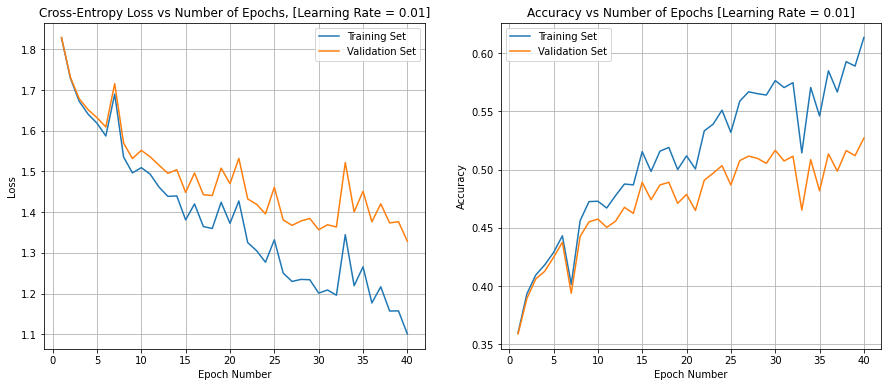

In [111]:
MLP_plots(40, 0.01)

Firstly we notice that as the number of epochs increases, the general trend is that the percentage accuracy increases whilst the loss decreases.

The loss and accuracies start of the same for both the training and validation sets, however we observe that the gap between them increases with the number of epochs. The model performs better for the training set than the validation one in the long run, and this is expected as the model is trained only using the training set.

However we can note that the curves are not smooth, instead they have spikes where the model can perform slightly worse on the next iteration. This might be explained by the fact that we are using stochastic gradient descent as our optimizer. As this involves taking a sample of datapoints, this means we only have a noisy estimate of the true gradient,and so in some iterations, the gradient found might be in the direction of a local minimum of the loss function but not a global minimum that we require.

Also whilst the accuracy curves start to increase more slowly with a greater number of epochs, they do not significantly decrease beyond the trend which suggests that overfitting has not yet occured.

#### Question 1.1.2 <a class="anchor" id="1_1_2"></a>
***

We use the same functions above to train the MLP with different learning rates:

In [21]:
MLP_Metrics["40, 0.0001"] = MLP(40, 0.0001)
print('Total Training Time  : ', MLP_Metrics["40, 0.0001"][2])
print(' ')

MLP_Metrics["40, 0.1"] = MLP(40, 0.1)
print('Total Training Time  : ', MLP_Metrics["40, 0.1"][2])

Epoch 5/ 40
Epoch 10/ 40
Epoch 15/ 40
Epoch 20/ 40
Epoch 25/ 40
Epoch 30/ 40
Epoch 35/ 40
Epoch 40/ 40
Total Training Time  :  00:12:01
 
Epoch 5/ 40
Epoch 10/ 40
Epoch 15/ 40
Epoch 20/ 40
Epoch 25/ 40
Epoch 30/ 40
Epoch 35/ 40
Epoch 40/ 40
Total Training Time  :  00:11:52


The plots obtained are:

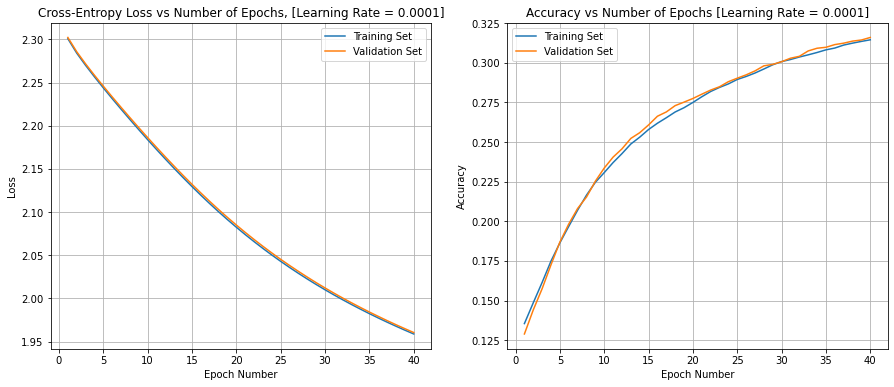

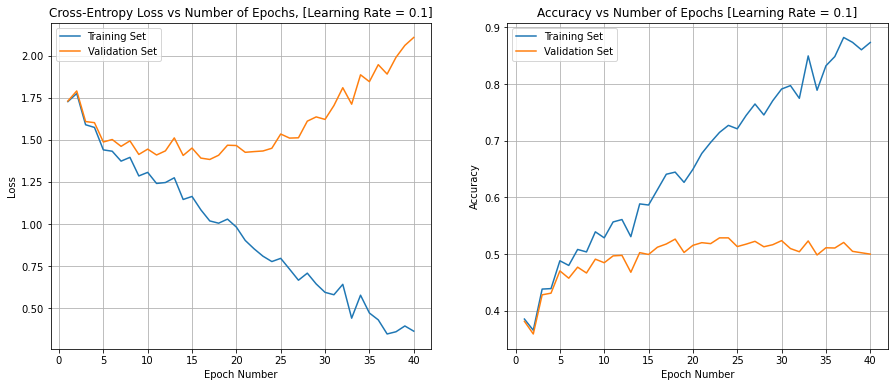

In [33]:
MLP_plots(40, 0.0001)
MLP_plots(40, 0.1)

Firstly we observe that changing the learning rate has a great effect on the behaviour of the model.

With a very small learning rate of 0.0001, we observe very smooth curves for both the loss and the accuracy, and the curves for the training and validation sets are almost overlapping.\
Furthermore, the curves are strictly monotonic so overfitting does not appear to have occured yet.

This can be explained by the fact that the learning rate is the step size used in stochastic gradient descent. So with a very small learning rate, the model will be less likely to "jump over" a local minima of a loss function and cause the loss to increase again.

On the other hand, with a larger learning rate of 0.1, we see that the curves are much more jagged, and also whilst the training set has a generally decreasing loss, the validation set has a loss curve that increases again after a global minimum approximately at Epoch 20. The validation accuracy curve also seems to level off, and not increase after about 20 epochs.

This does suggest that overfitting has occured, since the final model performs very well for the training set (accuracy of nearly 0.9), but the final validation accuracy is around 0.5. The jagged shape can be explained by the fact that with a high learning rate, the model can overshoot beyond the minima of the loss function.

When comparing the final validation accuracies, we see that it is around 0.3 for a learning rate of 0.0001 and 0.5 for a learning rate of 0.1. Thus in the latter model, even though overfitting has occured it performs better than the former model. So too small of a learning rate means that the convergence of the model is too slow and will require a greater number of epochs (and thus more computational power) to get similar results to that of a higher learning rate.

#### Question 1.1.3 <a class="anchor" id="1_1_3"></a>
***

Finally we train the MLP over 80 epochs with the learning rate 0.01 and again plot the metrics:

In [23]:
MLP_Metrics["80, 0.01"] = MLP(80, 0.01)
print('Total Training Time  : ', MLP_Metrics["80, 0.01"][2])

Epoch 5/ 40
Epoch 10/ 40
Epoch 15/ 40
Epoch 20/ 40
Epoch 25/ 40
Epoch 30/ 40
Epoch 35/ 40
Epoch 40/ 40
Epoch 45/ 40
Epoch 50/ 40
Epoch 55/ 40
Epoch 60/ 40
Epoch 65/ 40
Epoch 70/ 40
Epoch 75/ 40
Epoch 80/ 40
Total Training Time  :  00:23:35


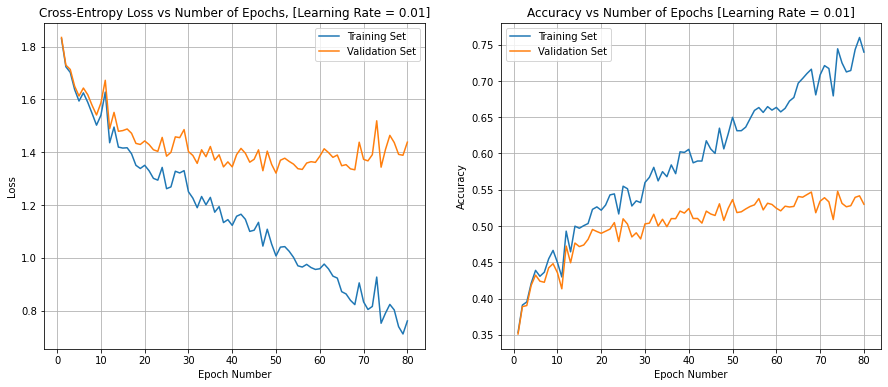

In [34]:
MLP_plots(80, 0.01)

Firstly we observe that the loss and accuracy curves are very similar to those in 1.1.1, however the gap between the training set curves and the validation set curves get much larger.\
This is expected as the model is only exposed to the training set whilst training, so as the model performs better and better for the training set, overfitting will start to occur as the model may pick up on features that only exist in the training sample but not the validation sample.

The final performance of the four models are summarised below:

In [244]:
def get_last_metrics(metric_list):
    final_loss = list(metric_list[0][-1])
    final_accuracy = list(metric_list[1][-1])
    train_time = str(metric_list[2])
    return final_loss + final_accuracy + [train_time]

MLP_comparison = pd.DataFrame(columns=['Training Loss', 'Validation Loss',
                                       'Training Accuracy', 'Validation Accuracy','Training Time'],
                              index=['40 Epochs, $\eta$ = 0.0001', '40 Epochs, $\;\;\: \eta$ = 0.01',
                                     '40 Epochs, $\quad\; \eta$ = 0.1', '80 Epochs, $\;\;\: \eta$ = 0.01'],
                              data = [get_last_metrics(MLP_Metrics["40, 0.0001"]),
                                               get_last_metrics(MLP_Metrics["40, 0.01"]),
                                               get_last_metrics(MLP_Metrics["40, 0.1"]),
                                               get_last_metrics(MLP_Metrics["80, 0.01"])])

MLP_comparison

KeyError: '40, 0.0001'

We see that the "best" model in terms of validation accuracy is the one for 80 epochs and a learning rate of 0.01, however this is only marginally higher than that of 40 epochs, but it takes almost twice as long in computational time.

This suggests that the validation accuracy for the 80 epochs model has levelled off, and this is apparent in the graph above where it sharply increases, but stays approximately the same after about 40 epochs. However the training accuracy keeps increasing, so after a certain number of epochs, the model will learn features only specific to that training set sample of datapoints, and so will not necessarily improve when evaluated against the validation set.

The learning rates also seem to have a great effect on the final validation accuracy.\
As explained above, the update rule in stochastic gradient descent is: $\theta_{t+1} = \theta_t - \eta \Delta_{\theta} L (\theta_t; \mathcal{D}_m)$

So $\eta = 0.0001$ is too small and the small step size results in slow convergence to the minimum of the loss function, on the other hand $\eta = 0.1$ is too large and quickly converges to a local minimum of the loss function, but the does not learn enough features so the model results in overfitting. For this $\eta$ the training loss is the lowest of the models, but the validation loss is the highest. So it is clear that careful combination of hyperparameters is required to get the optimal model.

Furthermore, in all the models above, we have not implemented any form of regularisation.\
This is important as 5  hidden layers with 400 neurons each results in a very complex model with many parameters which can be prone to overfitting.

### 1.2 Convolutional Neural Network (CNN) <a class="anchor" id="q1_2"></a>
***

#### Question 1.2.1 <a class="anchor" id="1_2_1"></a>
***

First we process the data by loading it into tf.data.Dataset objects and batch them into batches of 128 data points as required:

In [41]:
# Dataset Objects
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# Batching
batch_size = 128
train_dataset_batched = train_dataset.batch(batch_size)
val_dataset_batched = val_dataset.batch(batch_size)

# Check the shapes are as expected
train_dataset_batched.element_spec

(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))

Now we can build the model according to the required architecture.

It should be noted that a Flatten layer is added in between the convolutional layers and the fully-connected (Dense) layers. This unrolls the dataset into a 1-dimensional object as the spatial structure is no longer used in the Dense layers.

In [51]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

model_1 = Sequential([
     Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
     MaxPool2D((2, 2)),
     Conv2D(64, (3, 3), activation='relu'),
     MaxPool2D((2, 2)),
     Conv2D(64, (3, 3), activation='relu'),
     Flatten(),
     Dense(64, activation='relu'),
     Dense(10, activation='softmax')])

model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

We also create a function to train the CNN model, in which we fix the optimisation to be SGD and use categorical cross-entropy as the loss function.\
The number of epochs and the learning rate are fixed at 40 and 0.1 respectively.\
There is an optional parameter to add callbacks which is used in latter parts.

In [52]:
def train_CNN(model, callback=None):
    start = time.time()
    
    # Define the Optimization method and Loss function
    sgd = tf.keras.optimizers.SGD(learning_rate=0.1)
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    
    model.compile(optimizer=sgd, loss=loss_fn, metrics=['categorical_accuracy'])
    
    # Train the model using the training set (adding a callback if given)
    if callback:
        history = model.fit(train_dataset_batched, epochs=40, validation_data=val_dataset_batched, verbose=0,
                            callbacks = [callback])
    else:
        history = model.fit(train_dataset_batched, epochs=40, validation_data=val_dataset_batched, verbose=0)
    
    # Calculate the time taken
    time_diff = time.time() - start
    train_time = time.strftime("%H:%M:%S", time.gmtime(time_diff))
    
    # Return the metrics
    return history, train_time

We train the model by calling this function:

In [53]:
history_1, train_time_1 = train_CNN(model_1)
print('Total Training Time  : ', train_time_1)

Total Training Time  :  00:17:21


We also create a function to plot the losses and accuracies given the history of the model:

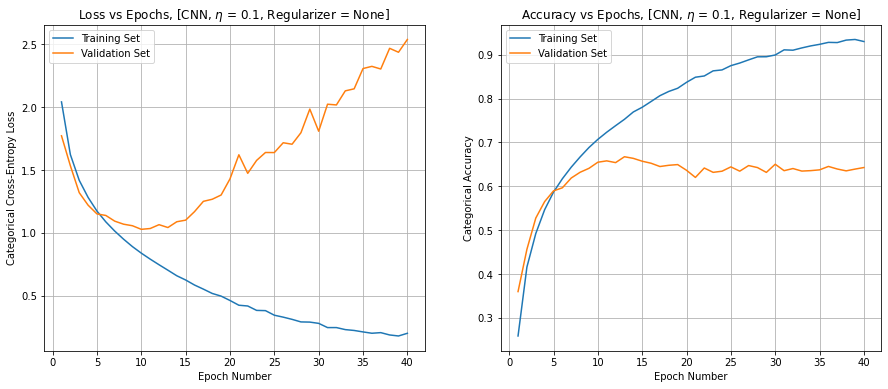

In [231]:
def CNN_plots(history, reg_info):
    # PLot of losses and accuracies
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    
    x_axis = np.arange(len(val_acc)) + 1
    ax0.set_title("Loss vs Epochs, " + 
                  "[CNN, $\eta$ = 0.1, Regularizer = " + reg_info + "]")
    ax0.plot(x_axis, train_loss, label = "Training Set")
    ax0.plot(x_axis, val_loss, label = "Validation Set")
    ax0.legend()
    ax0.grid()
    ax0.set_xlabel("Epoch Number")
    ax0.set_ylabel("Categorical Cross-Entropy Loss")
    
    ax1.set_title("Accuracy vs Epochs, " + 
                  "[CNN, $\eta$ = 0.1, Regularizer = " + reg_info + "]")
    ax1.plot(x_axis, train_acc, label = "Training Set")
    ax1.plot(x_axis, val_acc, label = "Validation Set")
    ax1.legend()
    ax1.grid()
    ax1.set_xlabel("Epoch Number")
    ax1.set_ylabel("Categorical Accuracy")
    plt.show()
    
    return

CNN_plots(history_1, "None")

Firstly, we oberserve smooth curves for the loss and accuracy of the training set. The fact that these appear to be monotonic indicates that training is occuring as expected, with a final training accuracy of over 0.9 at Epoch 40.

On the other hand the validation set curves are much more jagged. For the loss, the curve appears to have a local minimum at around 10 epochs before increasing beyond the starting loss, and the validation accuracy seems to level off at around 0.65 from Epoch 10 onwards. \
The quickly increasing validation loss, whilst training loss is decreasing, does seem to suggest that overfitting may be occuring.

#### Question 1.2.2 <a class="anchor" id="1_2_2"></a>
***

Here we implement L2 regularisation (which is a form of weight regularisation) to the convolutional layers of the model.

In [232]:
from tensorflow.keras import regularizers

model_2 = Sequential([
     Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(5e-3), activation='relu', input_shape=(32, 32, 3)),
     MaxPool2D((2, 2)),
     Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(5e-3), activation='relu'),
     MaxPool2D((2, 2)),
     Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(5e-3), activation='relu'),
     Flatten(),
     Dense(64, activation='relu'),
     Dense(10, activation='softmax')])

model_2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)               

Once again we train the model and plot the metrics:

In [56]:
history_2, train_time_2 = train_CNN(model_2)
print('Total Training Time  : ', train_time_2)

Total Training Time  :  00:16:57


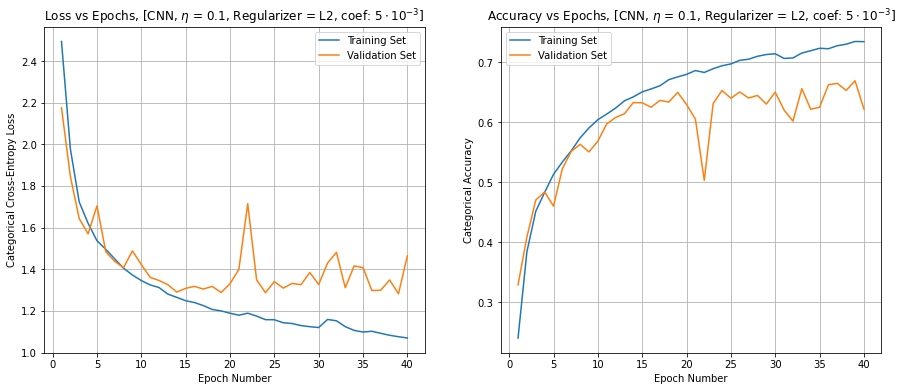

In [233]:
CNN_plots(history_2, "L2, coef: $5 \cdot 10^{-3}$")

With the added L2 regularisation, we observe that the difference between the training and validation curves is not as stark as before. Further, the general trend of the validation loss curve does not seem to be increasing, with the exception of a large spike at Epoch 22 which may just be due to the random element of the optimization method.

So we see that overfitting is less likely to be occuring here.\
Comparing the final accuracies, we see that the final final training accuracy is only around 0.7, compared to 0.9 previously, however the validation accuracies are in the same ballpark of approximately 0.65.

L2 regularisation adds a penalty term to the loss function which is a proportional to the sum of the square of the weight coefficients:
$$ \textrm{Loss} = \textrm{Cross-Entropy Loss} + \frac{\lambda}{2} \sum_j w_j^2$$
where $\lambda$ is the regularisation coefficient.
This ensures that the magnitudes of the weight terms do not get too large.

If we did not restrict this, the weights will be unbounded so they can grow in order to better identify the specific features in the training data. However this makes the model very prone to overfitting as the specific neural network might only be suited to the specific sample data in the training data, and hence the model will not be as generalisable.

#### Question 1.2.3 <a class="anchor" id="1_2_3"></a>
***

Firstly we implement Dropout with a rate of 0.5 to the model from 1.2.1.

In [58]:
from tensorflow.keras.layers import Dropout

model_3= Sequential([
     Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
     MaxPool2D((2, 2)),
     Conv2D(64, (3, 3), activation='relu'),
     MaxPool2D((2, 2)),
     Conv2D(64, (3, 3), activation='relu'),
     Flatten(),
     Dense(64, activation='relu'),
     # Dropout added Here
     Dropout(0.5),
     Dense(10, activation='softmax')])

In [59]:
history_3, train_time_3 = train_CNN(model_3)
print('Total Training Time  : ', train_time_3)

Total Training Time  :  00:16:43


Next we implement Early Stopping as an alternative method of weight regularisation.

In [61]:
history_4, train_time_4 = train_CNN(model_4, callback = earlystopping)
print('Total Training Time  : ', train_time_4)

Total Training Time  :  00:08:32


We then can see the plots for the model for the 2 regularisation methods below:

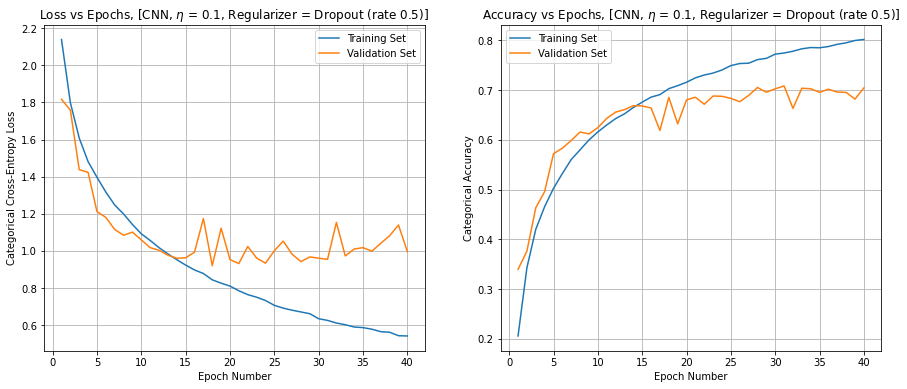

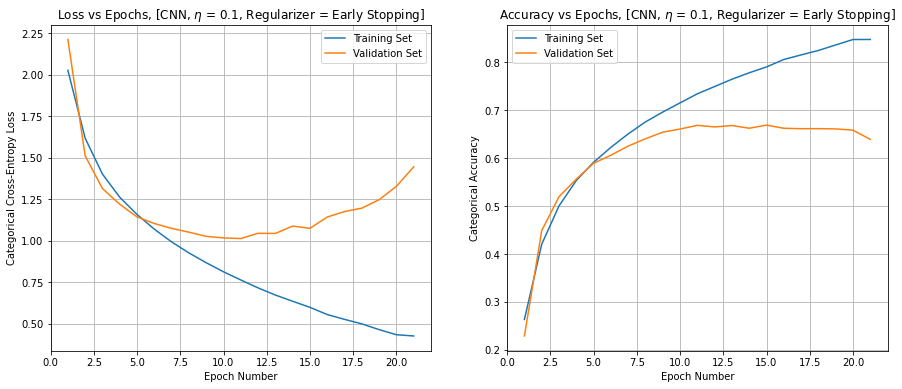

In [234]:
CNN_plots(history_3, "Dropout (rate 0.5)")

CNN_plots(history_4, "Early Stopping")

In terms of model performance, we observe that the final validation accuracy for the model with Dropout is just over 0.7, which is greater than the previous 2 CNN models above. Whereas the validation accuracy for the model with Early Stopping is similar to those above at around 0.65.

With both these regularisation methods, the training and validation curves seem to overlap before widening and creating a gap halfway through training.

Dropout:\
We used Dropout in between the two fully-connected (Dense) layers of the model.  This is because the effect of dropout is to randomly drop connections between two layers in a neural network to reduce interdependency in the hidden layers. So it would make sense to implement it between the layers with the most number of parameters that are likely to co-adapt and cause overfitting (i.e. in the Dense layers).

This does appear to be somewhat working as the final validation accuracy is higher than the previous 2 models. However it is only an increase in 0.05, we would need to experiment with adding multiple Dropout layers in different places and also changing the dropout probability rate. If we had more time and computational resources, we could use a grid search method to find the optimal Dropout parameters.

Early Stopping:\
In the case of Early Stopping, we chose to use validation loss as the metric to monitor. This regularisation method tracks the validation loss after each epoch, and stops the training of the model if the loss does not keep decreasing after a the "patience" threshold of epochs (here we set patience = 10). This has the effect of avoiding over-training the model to the training data, hence reducing overfitting.

We can immediately see the effect of this as the model has stopped training after only 21 Epochs, as the validation loss did not decrease beyond the value at the 11th Epoch. The final validation accuracy is approximately the same as that for the L2 regularisation model above. However it is not as high as the model with Dropout, which suggests that we may need to adjust the patience parameter to add some more leeway.

In the ideal scenario, we would implement a combination of the regularization methods mentioned above as they all serve slightly different roles and it is hard to compare them using only one specific model. However again finding the right balance of regularization methods and parameters to use is important as if we are too strict, underfitting might occur.

#### Question 1.2.4 <a class="anchor" id="1_2_4"></a>
***

First we can see the structure of the MLP model from 1.1.1 by building the model outline on tensorflow.\
We then retrieve the total number of parameters from both models of interest.

In [69]:
MLP_model = Sequential([
     Flatten(input_shape=(32, 32, 3)),
     Dense(400, activation='tanh'),
     Dense(400, activation='tanh'),
     Dense(400, activation='tanh'),
     Dense(400, activation='tanh'),
     Dense(400, activation='tanh'),
     Dense(10, activation='softmax')])

MLP_model.summary()
MLP_parameters = MLP_model.count_params()
CNN_parameters = model_3.count_params()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 400)               1229200   
_________________________________________________________________
dense_25 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_26 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_27 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_28 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_29 (Dense)             (None, 10)               

Now we can summarise the various performance metrics and model differences in the table below:

In [242]:
MLP_metrics_1 = get_last_metrics(MLP_Metrics["40, 0.01"]) + [MLP_parameters]

CNN_metrics = [history_3.history['loss'][-1],
               history_3.history['val_loss'][-1], 
               history_3.history['categorical_accuracy'][-1], 
               history_3.history['val_categorical_accuracy'][-1], 
               train_time_3,
               CNN_parameters]


NN_comparison = pd.DataFrame(columns=['Training Loss', 'Validation Loss',
                                       'Training Accuracy', 'Validation Accuracy',
                                       'Computational Time', 'Number of Parameters'],
                              index=['MLP: 40 Epochs, $\eta$ = 0.01', 'CNN: 40 Epochs, $\,\: \eta$ = 0.1'],
                              data = (MLP_metrics_1, CNN_metrics))

NN_comparison

,Training Loss,Validation Loss,Training Accuracy,Validation Accuracy,Computational Time,Number of Parameters
"MLP: 40 Epochs, $\eta$ = 0.01",1.100864,1.328459,0.61350,0.5271,00:12:25,1874810
"CNN: 40 Epochs, $\,\: \eta$ = 0.1",0.541121,0.995536,0.80162,0.7043,00:16:43,122570


We first observe that the performance of the CNN model is much better than that of the MLP model when judging by the validation accuracy, with an approximately 34% increase in accuracy.

It is also notable that the number of parameters for the MLP is more than 15 times greater than that for the CNN. Although having a greater number of model parameters allows for more flexibility, it also makes it more prone to overfitting to the training data. 

Furthermore, the CNN model makes up for the lack of parameters by introducing more model complexity between the hidden layers using the convolution operation. These are more computationally intensive tasks compared to the ones in the MLP and this is reflected by the increase in computation time for CNN despite having fewer parameters.

We can also get the plots of the two models on the same axes:

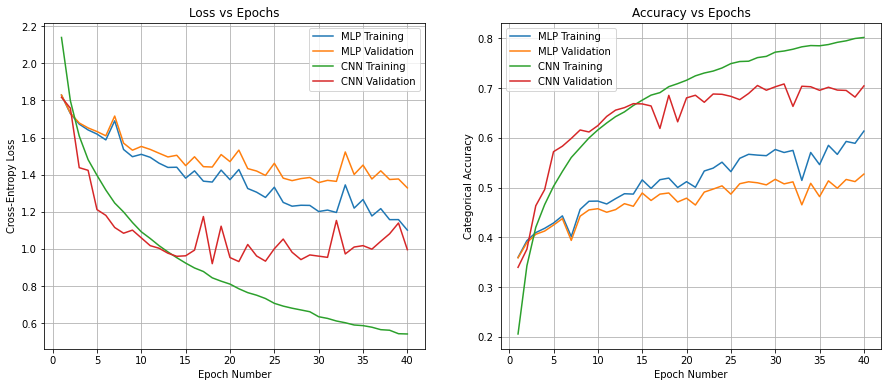

In [245]:
MLP_train_loss = np.array(MLP_Metrics["40, 0.01"][0])[:, 0]
MLP_val_loss = np.array(MLP_Metrics["40, 0.01"][0])[:, 1]
MLP_train_acc = np.array(MLP_Metrics["40, 0.01"][1])[:, 0]
MLP_val_lacc = np.array(MLP_Metrics["40, 0.01"][1])[:, 1]

CNN_train_loss = history_3.history['loss']
CNN_val_loss = history_3.history['val_loss']
CNN_train_acc = history_3.history['categorical_accuracy']
CNN_val_acc = history_3.history['val_categorical_accuracy']

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
x_axis = np.arange(40) + 1
ax0.set_title("Loss vs Epochs")
ax0.plot(x_axis, MLP_train_loss, label = "MLP Training")
ax0.plot(x_axis, MLP_val_loss, label = "MLP Validation")
ax0.plot(x_axis, CNN_train_loss, label = "CNN Training")
ax0.plot(x_axis, CNN_val_loss, label = "CNN Validation")
ax0.legend()
ax0.grid()
ax0.set_xlabel("Epoch Number")
ax0.set_ylabel("Cross-Entropy Loss")

ax1.set_title("Accuracy vs Epochs")
ax1.plot(x_axis, MLP_train_acc, label = "MLP Training")
ax1.plot(x_axis, MLP_val_lacc, label = "MLP Validation")
ax1.plot(x_axis, CNN_train_acc, label = "CNN Training")
ax1.plot(x_axis, CNN_val_acc, label = "CNN Validation")
ax1.legend()
ax1.grid()
ax1.set_xlabel("Epoch Number")
ax1.set_ylabel("Categorical Accuracy")
plt.show()

The CNN model metrics consistently appear to outperform their respective metrics for the MLP model beyond an initial few epochs.

It is also notable that the validation accuracy curve for the CNN model seems to well be above the training accuracy curve for the MLP model.

Once again these differences can be explained by the complex nature of the hidden layers in the CNN model. Furthermore we did not implement any regularisation in the MLP model, but we did include Dropout in the CNN model which further aids model training.

One thing to note is that we used different learning rates for stochastic gradient descent in the two models (0.01 for MLP and 0.1 for CNN), so a simple comparison between these two specific models might not be appropriate. If we wanted a more in depth comparison and had more computational resources, we would train both models over a range of different hyperparameters including learning rates, regularization methods and number of epochs.

Finally, we can also plot some example images from the validation set and see their categorical distributions as predicted by the two models:

In [246]:
def plot_examples(preds_1, preds_2, inx):
    # Obtain the categorical distributions of the predictions
    random_preds_1 = preds_1[random_inx, ...]
    random_preds_2 = preds_2[random_inx, ...]
    random_test_images = x_val[random_inx, ...]
    random_test_labels = y_val_labels[random_inx]
    
    # Create a 4x3 grid of subplots
    fig, axes = plt.subplots(4, 3, figsize=(16, 12))
    fig.subplots_adjust(hspace=0.6, wspace=0.2)
    
    for i, (prediction_1, prediction_2, image, label) in enumerate(zip(random_preds_1, random_preds_2, 
                                                                       random_test_images, random_test_labels)):
        # Example Images
        axes[i, 0].imshow(image)
        axes[i, 0].get_xaxis().set_visible(False)
        axes[i, 0].get_yaxis().set_visible(False)
        axes[i, 0].set_title(f'{classes[label]}')
        
        # MLP Distributions
        axes[i, 1].bar(classes, prediction_1)
        axes[i, 1].set_xticks(np.arange(len(prediction_1)))
        axes[i, 1].set_title(f"MLP Model prediction: {classes[np.argmax(prediction_1)]}")
        
        # CNN Distributions
        axes[i, 2].bar(classes, prediction_2)
        axes[i, 2].set_xticks(np.arange(len(prediction_2)))
        axes[i, 2].set_title(f"CNN Model prediction: {classes[np.argmax(prediction_2)]}")
        
        # Formatting
        for j in [1, 2]:
            axes[i, j].set_ylim(0, 1)
            axes[i, j].tick_params('x', labelrotation=45, labelsize='small')
            
    plt.show()
    return

In [253]:
# Fix some random indices
random_inx = np.random.choice(10000, 4, replace=False)

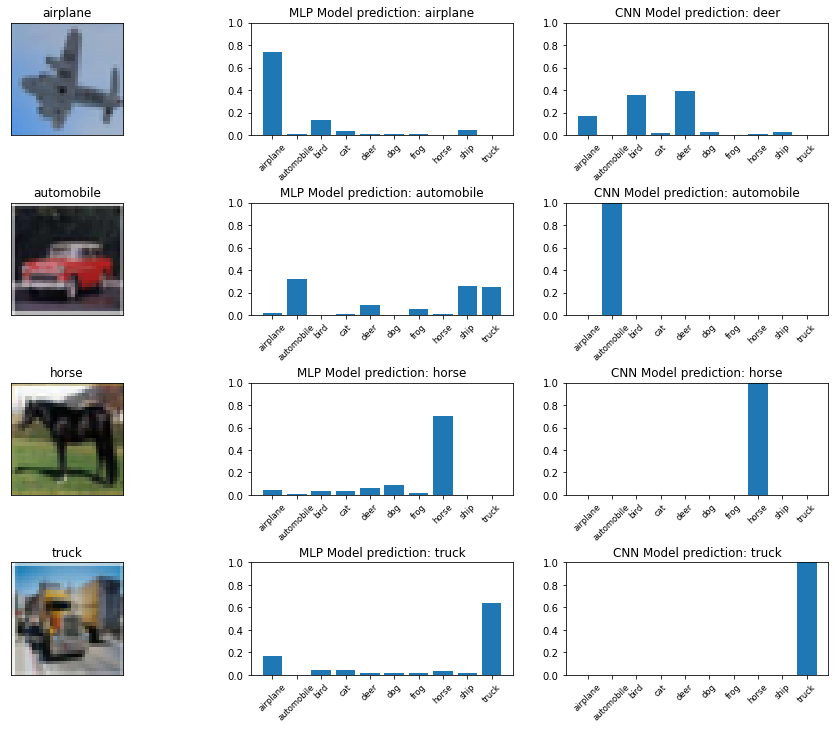

In [254]:
preds_1 = MLP_Metrics["40, 0.01"][-1].T
preds_2 = model_3.predict(x_val)
plot_examples(preds_1, preds_2, random_inx)

After repeating this for various samples, it becomes apparent that the CNN model in general seems to be more 'confident' in its prediction, whilst the MLP model dsitributes the probability over more classes.

## Task 2: Unsupervised Learning <a class="anchor" id="t2"></a>
***

### 2.1 Clustering of the Feature Matrix <a class="anchor" id="q2_1"></a>
***

#### Question 2.1.1 <a class="anchor" id="2_1_1"></a>
***

#### Question 2.1.2 <a class="anchor" id="2_1_2"></a>
***

#### Question 2.1.3 <a class="anchor" id="2_1_3"></a>
***

### 2.2 Dimensionality Reduction of the Feature Matrix <a class="anchor" id="q2_2"></a>
***

#### Question 2.2.1 <a class="anchor" id="2_2_1"></a>
***

#### Question 2.2.2 <a class="anchor" id="2_2_2"></a>
***

### 2.3 Graph-Based Analysis <a class="anchor" id="q2_3"></a>
***

#### Question 2.3.1 <a class="anchor" id="2_3_1"></a>
***

#### Question 2.3.2 <a class="anchor" id="2_3_2"></a>
***

#### Question 2.3.3 <a class="anchor" id="2_3_3"></a>
***

## End of Coursework